In [1]:
%run imports.ipynb

In [2]:
import dadi
from dadi import Numerics
from dadi import PhiManip
from dadi import Integration
from dadi import Spectrum
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import pylab

In [3]:
callset = callset_biallel
accessibility_fn = accessibility
contigs = ('3R')

In [4]:
allele_counts = zarr.open('data/phase2_biallel_allele_count.zarr/')
list(allele_counts['3R'].keys())

['AOcol',
 'BFcol',
 'BFgam',
 'CIcol',
 'CMgam',
 'FRgam',
 'GAgam',
 'GHcol',
 'GHgam',
 'GM',
 'GNcol',
 'GNgam',
 'GQgam',
 'GW',
 'KE',
 'UGgam']

In [5]:
outgroup_alleles = h5py.File('data/outgroup_alleles_phase2.h5', mode = 'r')
annotation = zarr.open('data/ag1000g.phase2.ar1.pass.biallelic_snpeff/')

In [6]:
ann = annotation['3R']['variants/ANN_Annotation'][:]

In [7]:
cond_inter = ann == 'intergenic_region'
cond_inter, len(cond_inter)

(array([False, False, False, ...,  True,  True,  True]), 10752701)

In [8]:
outgroups = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [9]:
def consensus_aa(chrom, *outgroups):
    aa = None
    for species in outgroups:
        if aa is None:
            aa = outgroup_alleles[chrom][species][:]
        else:
            loc_consensus = aa == outgroup_alleles[chrom][species][:]
            aa[~loc_consensus] = b'.'
    return aa

In [10]:
cons_4 = consensus_aa('3R', 'arab', 'chri', 'epir', 'mela', 'meru', 'quad')
(cons_4 != b'.').sum()

4177105

In [11]:
cons_4

array([b'A', b'A', b'.', ..., b'.', b'.', b'.'], dtype='|S1')

In [12]:
pos = callset['3R']['variants']['POS'][:]
pos, pos.shape

(array([    9526,     9531,     9544, ..., 53195269, 53195273, 53195279],
       dtype=int32), (10752701,))

In [13]:
def get_neutral(chrom, pos):
    if chrom == '3R':
        cond = (pos > 1000000) & (pos < 37000000)
    return cond

In [14]:
cond_neut = get_neutral('3R', pos)
cond_neut, len(cond_neut)

(array([False, False, False, ..., False, False, False]), 10752701)

In [15]:
pops = ['AOcol',
         'BFcol',
         'BFgam',
         'CIcol',
         'CMgam',
         'FRgam',
         'GAgam',
         'GHcol',
         'GHgam',
         'GM',
         'GNcol',
         'GNgam',
         'GQgam',
         'GW',
         'KE',
         'UGgam']

In [16]:
genotypes = allel.GenotypeChunkedArray(callset_biallel['3R']["calldata/GT"])
genotypes

<GenotypeChunkedArray shape=(10752701, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=22.9G cbytes=-1 cratio=-24559169084.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [17]:
sample_selection = metadata.population.isin(pops).values

In [18]:
metadata = pd.read_csv('samples.meta.txt', sep = "\t")
metadata

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,AY0087-C,Tia_dPM_46,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,101458232,32.56,ERS311822,5.89839,-4.82293
1138,AY0088-C,Tia_dPM_52,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,95140584,30.75,ERS311830,5.89839,-4.82293
1139,AY0089-C,Tia_aPM_4,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,92383724,29.04,ERS311838,5.89839,-4.82293
1140,AY0090-C,Tia_aPM_13,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,96210618,30.94,ERS311846,5.89839,-4.82293


In [19]:
samples_subset = metadata[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)

In [20]:
samples_subset.population.value_counts()

CMgam    297
UGgam    112
BFgam     92
GW        91
AOcol     78
BFcol     75
CIcol     71
GAgam     69
GM        65
GHcol     55
KE        48
GNgam     40
FRgam     24
GHgam     12
GQgam      9
GNcol      4
Name: population, dtype: int64

In [21]:
subpops = {
    'all': list(range(len(samples_subset))),
    'CMgam': samples_subset[samples_subset.population == 'CMgam'].index.tolist(),
    'UGgam': samples_subset[samples_subset.population == 'UGgam'].index.tolist(),
    'BFgam': samples_subset[samples_subset.population == 'BFgam'].index.tolist(),
    'GW': samples_subset[samples_subset.population == 'GW'].index.tolist(),
    'AOcol': samples_subset[samples_subset.population == 'AOcol'].index.tolist(),
    'BFcol': samples_subset[samples_subset.population == 'BFcol'].index.tolist(),
    'CIcol': samples_subset[samples_subset.population == 'CIcol'].index.tolist(),
    'GAgam': samples_subset[samples_subset.population == 'GAgam'].index.tolist(),
    'GM': samples_subset[samples_subset.population == 'GM'].index.tolist(),
    'GHcol': samples_subset[samples_subset.population == 'GHcol'].index.tolist(),
    'KE': samples_subset[samples_subset.population == 'KE'].index.tolist(),
    'GNgam': samples_subset[samples_subset.population == 'GNgam'].index.tolist(),
    'FRgam': samples_subset[samples_subset.population == 'FRgam'].index.tolist(),
    'GHgam': samples_subset[samples_subset.population == 'GHgam'].index.tolist(),
    'GQgam': samples_subset[samples_subset.population == 'GQgam'].index.tolist(),
    'GNcol': samples_subset[samples_subset.population == 'GNcol'].index.tolist()
}

In [22]:
allele_counts = genotypes.count_alleles_subpops(subpops, max_allele=3)
allele_counts

<AlleleCountsChunkedTable shape=(10752701,) dtype=[('AOcol', '<i4', (4,)), ('BFcol', '<i4', (4,)), ('BFgam', '<i4', (4,)), ('CIcol', '<i4', (4,)), ('CMgam', '<i4', (4,)), ('FRgam', '<i4', (4,)), ('GAgam', '<i4', (4,)), ('GHcol', '<i4', (4,)), ('GHgam', '<i4', (4,)), ('GM', '<i4', (4,)), ('GNcol', '<i4', (4,)), ('GNgam', '<i4', (4,)), ('GQgam', '<i4', (4,)), ('GW', '<i4', (4,)), ('KE', '<i4', (4,)), ('UGgam', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=2.7G cbytes=215.7M cratio=12.9
   values=allel.chunked.storage_zarr.ZarrTable>

In [23]:
ac = {}
for pop in subpops:
        ac[pop] = allel.AlleleCountsChunkedArray(allele_counts[pop][:])

In [24]:
ac_row = ac

In [25]:
def get_sfs(chrom, pop, cond_neut, outgroups):
    
    # call ancestral allele for intergenic variants in eucrom regions


        aa = cons_4[cond_neut & cond_inter]

        # extract variants
        variants = callset['3R']['variants']
        ref = variants['REF'][:][cond_neut & cond_inter]
        alt = variants['ALT'][:][cond_neut & cond_inter]


        # take just the ac for for intergenic variants in eucrom regions
        
        ac = ac_row[pop][cond_neut & cond_inter]

        print ("ac:", ac.shape)

        # locate biallelic segregating
        loc_bi_seg = (ac.allelism() == 2) & (ac[:, 0] > 0) & (ac[:, 1] > 0)

        # locate positions with missing calls
        an = ac.sum(axis=1)
        loc_nomiss = an == an.max()
    #     log(nnz(loc_nomiss))

        # locations to use
        loc_asc = loc_bi_seg & loc_nomiss
    #     log(nnz(loc_asc), chrom, *outgroups)
        ac = ac[loc_asc]
        aa = aa[loc_asc]
        ref = ref[loc_asc]
        alt = alt[loc_asc]

        # polarise
        dac = np.zeros(ac.shape[0], dtype='u4')
        dac[aa == ref] = ac[:, 1][aa == ref]
        dac[aa == alt] = ac[:, 0][aa == alt]

        # compute SFS
        sfs_raw = np.bincount(dac)

        sfs = sfs_raw[1:]



        return sfs

In [26]:
sfs = {}
for pop in pops:
        sfs[pop] = get_sfs('3R', pop, cond_neut, 'chri')

ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)
ac: (3651719, 4)


In [27]:
sfs

{'AOcol': array([24908, 12045,  8639,  6609,  5295,  4444,  3893,  3368,  2991,
         2542,  2423,  2098,  1942,  1812,  1587,  1389,  1405,  1177,
         1166,  1087,   941,   969,   961,   843,   763,   757,   686,
          663,   614,   610,   527,   542,   498,   478,   417,   445,
          423,   395,   328,   345,   329,   334,   319,   314,   304,
          281,   279,   272,   231,   239,   231,   217,   216,   218,
          216,   180,   208,   184,   171,   148,   171,   167,   151,
          157,   137,   143,   138,   140,   116,   124,   131,   112,
          118,   120,   113,   108,    98,    90,   114,    90,    94,
          100,    87,    90,    95,    91,    81,    95,    70,    69,
           89,    64,    63,    80,    56,    84,    57,    76,    71,
           55,    73,    60,    49,    64,    56,    64,    61,    51,
           50,    48,    56,    50,    47,    44,    56,    48,    46,
           55,    47,    37,    36,    26,    35,    29,    37,    3

In [28]:
agam_p4 = pyfasta.Fasta('data/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa')
sorted(agam_p4.keys())

['2L dna:chromosome chromosome:AgamP4:2L:1:49364325:1',
 '2R dna:chromosome chromosome:AgamP4:2R:1:61545105:1',
 '3L dna:chromosome chromosome:AgamP4:3L:1:41963435:1',
 '3R dna:chromosome chromosome:AgamP4:3R:1:53200684:1',
 'Mt dna:chromosome chromosome:AgamP4:Mt:1:15363:1',
 'UNKN dna:chromosome chromosome:AgamP4:UNKN:1:42389979:1',
 'X dna:chromosome chromosome:AgamP4:X:1:24393108:1',
 'Y_unplaced dna:chromosome chromosome:AgamP4:Y_unplaced:1:237045:1']

In [29]:
print('3R',len(agam_p4['3R dna:chromosome chromosome:AgamP4:3R:1:53200684:1']))

3R 53200684


In [30]:
l_eu_3R = 37e6 - 1e6
print('l 3R eu:', l_eu_3R)

l 3R eu: 36000000.0


In [31]:
# how many variants in euchromatic regions? 
n_variants_eu_3R = np.compress(cond_neut, pos).size
n_variants_eu_3R

8281765

In [32]:
# how many variants in euchromatic regions are intergenic? annot is already filtered with cond_neut
n_inter_variants_eu_3R = (annotation['3R']['variants/ANN_Annotation'][:]  == 'intergenic_region').sum()
n_inter_variants_eu_3R

4836524

In [33]:
prop_geno_3R = n_inter_variants_eu_3R / n_variants_eu_3R
prop_geno_3R

0.5839967688047174

In [34]:
actual_lenght_3R = int(l_eu_3R * prop_geno_3R)
print('l 3R actual genotyped:', actual_lenght_3R)

l 3R actual genotyped: 21023883


In [35]:
for pop in pops:
    with open('dadi/stairway/input_files/input_stairway_%s.tab' % pop ,'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow([pop, len(sfs[pop]) + 1, actual_lenght_3R, '1', len(sfs[pop])])
        writer.writerow([i for i in sfs[pop]])

--------------------------------------------------------------

In [36]:
df_gm = etl.fromcsv("dadi/stairway/input_files/input_stairway_GM.tab", delimiter="\t")
fs_gm = [int(float(i)) for i in df_gm[1]]

In [37]:
fs_gm = dadi.Spectrum(fs_gm)
fs_gm

Spectrum([-- 41546.0 25165.0 16837.0 12337.0 9022.0 7133.0 5598.0 4474.0 3530.0
 2983.0 2534.0 2181.0 1881.0 1535.0 1487.0 1320.0 1154.0 1041.0 924.0
 820.0 788.0 718.0 716.0 595.0 590.0 531.0 511.0 417.0 408.0 410.0 364.0
 312.0 338.0 304.0 270.0 286.0 225.0 259.0 219.0 238.0 221.0 218.0 161.0
 163.0 161.0 139.0 151.0 165.0 138.0 122.0 134.0 116.0 120.0 109.0 93.0
 94.0 75.0 108.0 107.0 92.0 79.0 67.0 60.0 67.0 79.0 81.0 57.0 67.0 79.0
 50.0 58.0 57.0 55.0 44.0 42.0 55.0 37.0 49.0 41.0 42.0 43.0 42.0 45.0
 44.0 33.0 31.0 22.0 30.0 22.0 33.0 34.0 24.0 22.0 22.0 26.0 18.0 26.0
 28.0 23.0 24.0 33.0 25.0 15.0 19.0 16.0 22.0 17.0 19.0 21.0 10.0 13.0
 12.0 17.0 10.0 10.0 15.0 14.0 13.0 13.0 5.0 16.0 9.0 8.0 16.0 13.0 8.0
 12.0 --], folded=False, pop_ids=None)

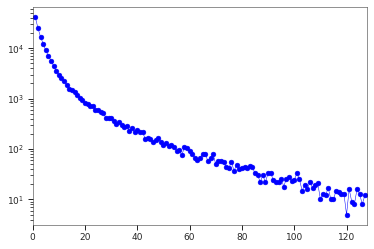

In [38]:
dadi.Plotting.plot_1d_fs(fs_gm)

In [39]:
ns = fs_gm.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])

In [40]:
def four_epoch(params, ns, pts):
    nu1, nu2, nu3, T1, T2, T3, p_misid = [1, 1, 1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    phi = Integration.one_pop(phi, xx, T2, nu2)
    phi = Integration.one_pop(phi, xx, T3, nu3)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)

In [41]:
params = np.array([1, 1, 1, 1, 1, 1, 0.01])

In [42]:
func_ex = dadi.Numerics.make_extrap_log_func(four_epoch)

In [43]:
model = func_ex(params, ns, pts)

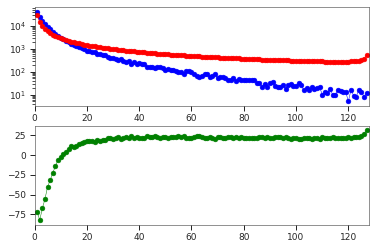

In [44]:
dadi.Plotting.plot_1d_comp_multinom(model, fs_gm)

-----------------------

In [45]:
df_gw = etl.fromcsv("dadi/stairway/input_files/input_stairway_GW.tab", delimiter="\t")
fs_gw = [int(float(i)) for i in df_gw[1]]

In [46]:
fs_gw = dadi.Spectrum(fs_gw)
fs_gw

Spectrum([-- 61443.0 31432.0 19405.0 13539.0 10124.0 7651.0 6032.0 4974.0 3961.0
 3540.0 2907.0 2601.0 2192.0 1904.0 1727.0 1524.0 1370.0 1216.0 1047.0
 1037.0 946.0 921.0 824.0 744.0 676.0 647.0 616.0 526.0 578.0 540.0 501.0
 452.0 449.0 394.0 344.0 353.0 349.0 317.0 321.0 283.0 279.0 249.0 260.0
 254.0 236.0 200.0 224.0 198.0 198.0 187.0 181.0 167.0 171.0 173.0 155.0
 152.0 138.0 144.0 107.0 134.0 140.0 97.0 99.0 109.0 122.0 88.0 111.0
 104.0 100.0 83.0 89.0 90.0 84.0 84.0 91.0 72.0 87.0 60.0 62.0 61.0 64.0
 51.0 66.0 78.0 51.0 57.0 47.0 45.0 50.0 56.0 50.0 46.0 42.0 51.0 46.0
 45.0 40.0 35.0 36.0 36.0 41.0 30.0 40.0 30.0 33.0 25.0 35.0 24.0 28.0
 25.0 30.0 35.0 30.0 35.0 38.0 21.0 27.0 33.0 30.0 32.0 22.0 21.0 31.0
 14.0 18.0 14.0 19.0 26.0 11.0 12.0 14.0 26.0 20.0 21.0 10.0 14.0 12.0
 21.0 24.0 20.0 18.0 15.0 17.0 15.0 8.0 6.0 13.0 9.0 16.0 18.0 14.0 8.0
 5.0 12.0 10.0 8.0 9.0 7.0 6.0 10.0 11.0 9.0 8.0 5.0 9.0 9.0 10.0 9.0 9.0
 9.0 6.0 11.0 14.0 8.0 11.0 9.0 8.0 9.0 8.0 --], folded

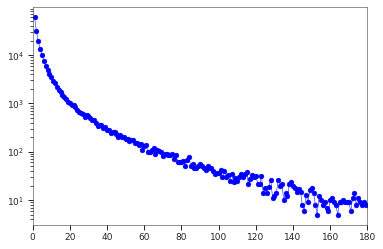

In [47]:
dadi.Plotting.plot_1d_fs(fs_gw)

In [48]:
ns = fs_gw.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])

In [49]:
model = func_ex(params, ns, pts)

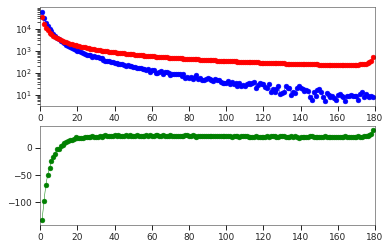

In [50]:
dadi.Plotting.plot_1d_comp_multinom(model, fs_gw)

--------------------------------

Is Kenya a bottleneck?

In [51]:
def bottleneck ( params , ns , pts ):
    
    """
    params = (nuB,nuF,TB,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TB: Length of bottleneck (in units of 2*Na generations) 
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    
    """
    
    nuB , nuF , TB , TF = [1, 1, 1, 1]
    xx = Numerics . default_grid ( pts )
    phi = PhiManip . phi_1D ( xx )
    phi = Integration . one_pop ( phi , xx , TB , nuB )
    phi = Integration . one_pop ( phi , xx , TF , nuF )
    fs = Spectrum . from_phi ( phi , ns , ( xx ,))
    return fs

In [52]:
df_ke = etl.fromcsv("dadi/stairway/input_files/input_stairway_KE.tab", delimiter="\t")
fs_ke = [int(float(i)) for i in df_ke[1]]

In [53]:
fs_ke = dadi.Spectrum(fs_ke)
fs_ke

Spectrum([-- 625.0 662.0 231.0 577.0 505.0 818.0 671.0 1332.0 473.0 944.0 2139.0
 922.0 381.0 726.0 669.0 875.0 1025.0 688.0 500.0 408.0 336.0 440.0 249.0
 310.0 610.0 278.0 260.0 428.0 250.0 320.0 610.0 555.0 260.0 376.0 185.0
 287.0 267.0 152.0 171.0 253.0 249.0 584.0 282.0 337.0 276.0 279.0 410.0
 221.0 243.0 206.0 253.0 571.0 308.0 498.0 197.0 145.0 431.0 387.0 113.0
 109.0 66.0 232.0 170.0 142.0 182.0 338.0 62.0 57.0 181.0 98.0 74.0 133.0
 227.0 117.0 117.0 54.0 51.0 141.0 68.0 139.0 71.0 77.0 136.0 82.0 54.0
 78.0 23.0 35.0 40.0 28.0 16.0 40.0 31.0 --], folded=False, pop_ids=None)

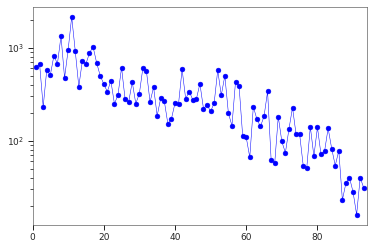

In [54]:
dadi.Plotting.plot_1d_fs(fs_ke)

In [55]:
ns = fs_ke.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])

In [56]:
func_ex = dadi.Numerics.make_extrap_log_func(bottleneck)

In [57]:
model = func_ex(params, ns, pts)

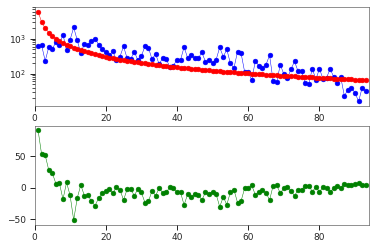

In [58]:
dadi.Plotting.plot_1d_comp_multinom(model, fs_ke)

-----------------------------------
What are Far West pops?

In [59]:
def growth(params, ns, pts):
    """
    Exponential growth beginning some time ago.
    params = (nu,T)
    ns = (n1,)
    nu: Ratio of contemporary to ancient population size
    T: Time in the past at which growth began (in units of 2*Na 
       generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    nu_func = lambda t: np.exp(np.log(nu) * t/T)
    phi = Integration.one_pop(phi, xx, T, nu_func)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

In [60]:
params = [1,1]

Pop name: Gambia


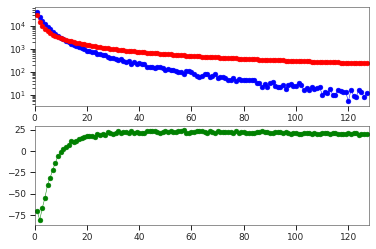

In [61]:
ns = fs_gm.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(growth)
model = func_ex(params, ns, pts)
print ('Pop name: Gambia')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gm)

Pop name: Guinea-Bissau


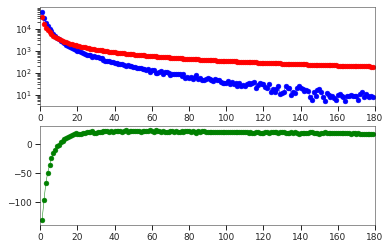

In [62]:
ns = fs_gw.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(growth)
model = func_ex(params, ns, pts)
print ('Pop name: Guinea-Bissau')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gw)

In [63]:
def bottlegrowth(params, ns, pts):
    """
    Instantanous size change followed by exponential growth.
    params = (nuB,nuF,T)
    ns = (n1,)
    nuB: Ratio of population size after instantanous change to ancient
         population size
    nuF: Ratio of contemporary to ancient population size
    T: Time in the past at which instantaneous change happened and growth began
       (in units of 2*Na generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nuB,nuF,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    nu_func = lambda t: nuB*np.exp(np.log(nuF/nuB) * t/T)
    phi = Integration.one_pop(phi, xx, T, nu_func)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

In [64]:
params = [1,1,1]

Pop name: Gambia


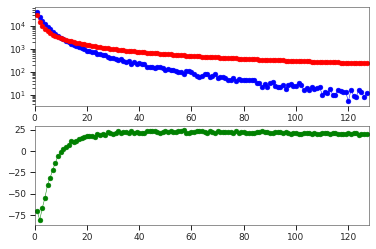

In [65]:
ns = fs_gm.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(bottlegrowth)
model = func_ex(params, ns, pts)
print ('Pop name: Gambia')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gm)

Pop name: Guinea-Bissau


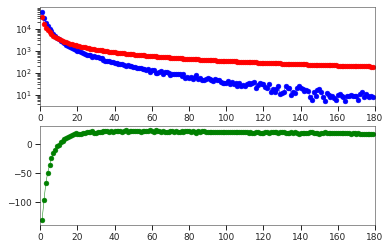

In [66]:
ns = fs_gw.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(bottlegrowth)
model = func_ex(params, ns, pts)
print ('Pop name: Guinea-Bissau')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gw)

In [67]:
def snm(notused, ns, pts):
    """
    Standard neutral model.
    ns = (n1,)
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

Pop name: Gambia


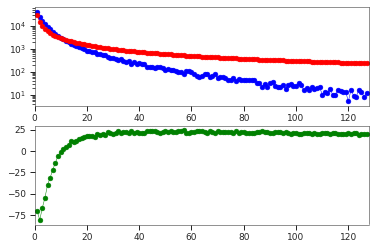

In [68]:
ns = fs_gm.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(snm)
model = func_ex(params, ns, pts)
print ('Pop name: Gambia')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gm)

Pop name: Guinea-Bissau


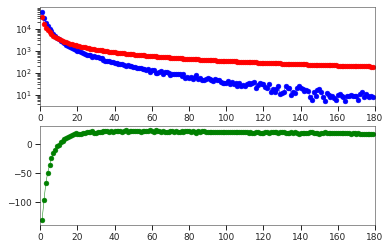

In [69]:
ns = fs_gw.sample_sizes
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(snm)
model = func_ex(params, ns, pts)
print ('Pop name: Guinea-Bissau')
dadi.Plotting.plot_1d_comp_multinom(model, fs_gw)

----------------

---------------------------------------
## 2 pops model?

In [73]:
fs_fw = dadi.Spectrum(np.load("dadi/fs_2_pops/GM_GW.npy"), pop_ids = ['GM', 'GW'])
fs_fw

Spectrum([[-- 142068.0 37092.0 ... 0.0 0.0 0.0]
 [39777.0 17181.0 9725.0 ... 0.0 0.0 0.0]
 [14933.0 8036.0 5498.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 2.0 1.0]
 [0.0 0.0 0.0 ... 0.0 2.0 3.0]
 [0.0 0.0 0.0 ... 3.0 8.0 --]], folded=False, pop_ids=['GM', 'GW'])

In [74]:
ns = np.array([max(fs_fw.sample_sizes[0], fs_fw.sample_sizes[1])])
ns

array([182])

In [75]:
ns = fs_fw.sample_sizes
ns

array([130, 182])

In [76]:
pts = ns + 30
pts

array([160, 212])

In [77]:
xx = Numerics.default_grid(pts[0])
xx.size

160

In [78]:
phi = PhiManip.phi_1D(xx)
phi = PhiManip.phi_1D_to_2D(xx , phi)
phi = Integration.two_pops(phi ,xx ,1 ,1 ,1 ,1 ,1)

In [79]:
print(phi.ndim, len(ns), len((xx,xx)))

2 2 2


In [80]:
fs = Spectrum.from_phi(phi , pts, (xx,xx))

In [88]:
def IM ( params , ns , pts ):
        s , nu1 , nu2 ,T , m12 , m21 = [0.5, 1, 1, 1, 1, 1]
        xx = Numerics . default_grid ( pts )
        phi = PhiManip . phi_1D ( xx )
        phi = PhiManip . phi_1D_to_2D ( xx , phi )
        nu1_func = lambda t : s * ( nu1 / s )**( t / T )
        nu2_func = lambda t : (1 - s ) * ( nu2 /(1 - s ))**( t / T )
        phi = Integration.two_pops ( phi , xx , T , nu1_func , nu2_func , m12 = m12 , m21 = m21 )
        print(phi.ndim, len(ns), len((xx,xx)))
        fs = Spectrum.from_phi( phi , ns , ( xx , xx ))
        return fs

In [89]:
params = [1, 1, 1, 1, 1, 1]

[130 182]
2 2 2
2 2 2
Pop name: Guinea-Bissau


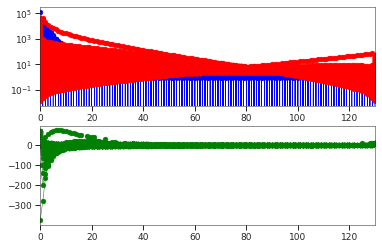

In [92]:
ns = fs_fw.sample_sizes[:]
print (ns)
pts = np.array([ns + 30, ns + 40, ns + 50, ns + 60])
func_ex = dadi.Numerics.make_extrap_log_func(IM)
model = func_ex(params, ns, pts[0])
print ('Pop name: Guinea-Bissau')
dadi.Plotting.plot_1d_comp_multinom(model, fs_fw)

ZeroDivisionError: float division by zero

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd6ea028d90> (for post_execute):


ValueError: values must all be positive

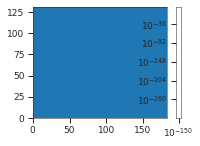

In [102]:
dadi.Plotting.plot_2d_comp_multinom(model, fs_fw)

ZeroDivisionError: float division by zero

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd6ea028d90> (for post_execute):


ValueError: values must all be positive

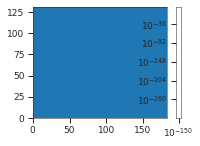

In [93]:
dadi.Plotting.plot_2d_comp_multinom(model, fs_fw)

In [81]:
def split_mig(params, ns , pts ):
    nu1 ,nu2 ,T ,m = [1, 1, 1, 1]
    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    phi = PhiManip.phi_1D_to_2D(xx , phi)
    phi = Integration.two_pops(phi ,xx ,1 ,1 ,1 ,1 ,1)
    fs = Spectrum.from_phi(phi ,ns ,( xx , xx))
    
    return fs

In [82]:
func_ex = dadi.Numerics.make_extrap_log_func(split_mig)

In [83]:
params = [1, 1, 1, 1]

In [84]:
model = func_ex(params, ns, pts[0])

In [85]:
model

Spectrum([[-- 1.0142376536128903 0.49296475188055344 ... 3.0250841458119064e-07
  1.9867529076049436e-07 9.87430456216838e-08]
 [0.9959218697569899 0.025222773494050662 0.015604584861077292 ...
  5.770319703023527e-07 3.8343073044321824e-07 1.9332390798137068e-07]
 [0.4784162253913591 0.01735002255532286 0.010066967133673553 ...
  8.375064296568318e-07 5.618844945381135e-07 2.8682323486964635e-07]
 ...
 [3.248473661502358e-07 6.129226405625991e-07 8.81183975998076e-07 ...
  0.00015352512682172018 0.0001892249009413546 0.001567719220707468]
 [2.0848555386643858e-07 3.9845898220454395e-07 5.785078435345558e-07 ...
  0.00017442917024789852 0.0002002995856335923 0.001683039501077771]
 [1.012849093924313e-07 1.9643269226633624e-07 2.885521344455759e-07 ...
  0.0012273781717468406 0.0013031382139644103 --]], folded=False, pop_ids=None)

In [95]:
model[1]

Spectrum([0.9609402926205951 0.019990217212353122 0.013328858697622802
 0.011037585875343323 0.009799718030236253 0.008980770944896556
 0.008370945324181455 0.007881489652009011 0.007468577326255397
 0.0071081220116418885 0.006785793712695948 0.006492523821538067
 0.0062222795416349 0.005970877211874017 0.005735310769537069
 0.005513352656331212 0.005303306693597478 0.005103849609876294
 0.004913926300901206 0.004732678751966042 0.004559396667486565
 0.004393482459822791 0.004234425954455376 0.0040817858046510985
 0.003935175624819852 0.0037942534979784567 0.003658713932630129
 0.0035282816225964703 0.00340270655097998 0.0032817601080834726
 0.003165231982622021 0.003052927648734346 0.0029446663164282823
 0.002840279245747593 0.0027396083488123264 0.002642505021525388
 0.0025488291598932547 0.002458448325817004 0.00237123703473127
 0.00228707614322066 0.002205852319195996 0.0021274575806477414
 0.0020517888917042223 0.0019787478068387676 0.0019082401557598818
 0.001840175762849397 0.00

ZeroDivisionError: float division by zero

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd6ea028d90> (for post_execute):


ValueError: values must all be positive

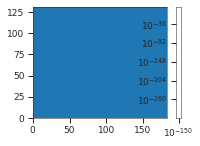

In [86]:
dadi.Plotting.plot_2d_comp_Poisson(model, fs_fw)

----------------------

studiare:

In [185]:
p0 = dadi.Misc.perturb_params(params, fold=1.5, lower_bound=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001], upper_bound=[100, 100, 100, 10, 10, 10, 0.1])
p0

array([1.4568798 , 1.16783439, 1.07716816, 0.38285406, 1.2330288 ,
       2.10647299, 0.01427669])

In [186]:
popt = dadi.Inference.optimize_log(p0, fs, func_ex, pts, lower_bound=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001], upper_bound=[100, 100, 100, 10, 10, 10, 0.1],
                                           verbose=len(params), maxiter=300, multinom=True) 
popt

14      , -37402      , array([ 1.45688    ,  1.16783    ,  1.07717    ,  0.383237   ,  1.23303    ,  2.10647    ,  0.0142767  ])


(array([1.4568798 , 1.16783439, 1.07716816, 0.38285406, 1.2330288 ,
        2.10647299, 0.01427669]), 37401.97390174589)

In [187]:
func_ex = dadi.Numerics.make_extrap_log_func(four_epoch)
model = func_ex(popt, ns, pts)

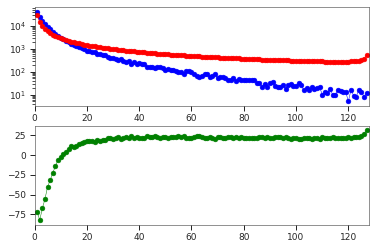

In [188]:
dadi.Plotting.plot_1d_comp_multinom(model, fs)